In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib.color_compass import bacon_shor_group, bsgauge_group, pauli2vector, pauli_weight, twisted_product, twisted_prod_mat
from termcolor import colored
from tqdm import tqdm

import pymatching

In [2]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def parity_check_matrix(self):
        """returns the full parity check matrix"""
        return np.vstack([self.pcheckX(), self.pcheckZ()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        
    # def error_is_corrected(self, syn, l_1, l_2, l_op):
    #     #syn is a vector of syndrome measurements, which has the Sx syndrome bits first
    #     #l_1, l_2 are booleans corresponding to the logical operator measurement
    #     #l_op is the logical operator we're measuring, written as a stim Pauli string

    #     #also need to know the stabilizers to feed into the decoder

    #     #check parity of l_1, l_2. If they are the same: no logical error
    #     #If they are different: logical error
    #     logical_error = ((l_1+l_2) % 2 == 0)

    #     #syndrome measurement gives a syndrome s. Feed into decoder to get a correction operator c
    #     #set up decoder
    #     Sx = lat.getSx()
    #     Sz = lat.getSz()
    #     Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
    #     Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
    #     Mx = Matching(Hx)
    #     Mz = Matching(Hz)

    #     #obtain correction operator
    #     cx = Mx.decode(syn[:len(Sx)])
    #     cz = Mz.decode(syn[len(Sx):])
    #     Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
    #     Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))

    #     correction_op = Rx*Rz



    #     #check [c, l]
    #         #If l_1 = l_2 and [c, l_op] = 0, then the error has been properly corrected
    #         #in that c keeps the proper eigenstate
    #         #If l_1 = l_2 and [c, l_op] \neq 0, then the decoder takes the state out of the correct eigenstate
    #         #If l_1 \neq l_2 and [c,l_op] = 0, then the decoder fails to correct the error
    #         #If l_1 \neq l_2 and [c, l_op] \neq 0, then the decoder properly corrects the error
    #     is_corrected = (correction_op.commutes(l_op) != logical_error)

    #     return is_corrected


def make_surface_code_lattice(dimX,dimZ,start='X'):
    if start == 'X':
        first_two_cells = [1,-1]
    elif start == 'Z':
        first_two_cells = [-1,1]
    first_row = (first_two_cells*int(np.ceil(dimZ/2)))
    first_two_rows = first_row[:dimZ-1] + first_row[1:dimZ]
    whole_lattice = first_two_rows*int(np.ceil(dimX/2))
    whole_lattice = whole_lattice[:(dimZ-1)*(dimX-1)]
    lat = Lattice2D(dimX, dimZ)
    lat.color_lattice(whole_lattice)
    return lat

In [3]:
def generate_all_pauli_strings(n):
    """
    generate all possible n-qubit Pauli strings
    """
    if n == 1:
        return ['I', 'X', 'Y', 'Z']
    else:
        return [p + q for p in generate_all_pauli_strings(1) for q in generate_all_pauli_strings(n-1)]
    
def index_to_pauli_string(idx, n):
    """
    convert an index to a Pauli string by converting the index to quaternary
    """
    return np.base_repr(idx, base=4).zfill(n).replace('0', 'I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')

In [5]:
# make a lattice and print
lat = make_surface_code_lattice(3,3)
print(lat)


000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [7]:
# show the parity check matrix
parity_check_matrix = lat.parity_check_matrix()
parity_check_matrix

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [8]:
def calculate_stabilizer_entropy_exact(parity_check_mat, error_distribution_func, error_rates):
    num_qubits = parity_check_mat.shape[1]/2
    assert num_qubits == int(num_qubits)
    num_qubits = int(num_qubits)
    syndrome_weight_dict = {}
    for i in tqdm(range(4**num_qubits)):
        pauli_string = index_to_pauli_string(i, num_qubits)
        pauli_bitstring = pauli2vector(pauli_string)
        syndrome = twisted_prod_mat(parity_check_mat, pauli_bitstring)
        syndrome_string = ''.join([str(int(s)) for s in syndrome])
        prob = error_distribution_func(pauli_string, *error_rates)
        if syndrome_string in syndrome_weight_dict.keys():
            syndrome_weight_dict[syndrome_string] += prob
        else:
            syndrome_weight_dict[syndrome_string] = prob
    return -np.sum([p*np.log2(p) for p in syndrome_weight_dict.values()])

def random_pauli(rates):
    p_i = 1-sum(rates)
    return np.random.choice(['I', 'X', 'Y', 'Z'], p=[p_i, rates[0], rates[1], rates[2]])

def calculate_stabilizer_entropy_emperical(parity_check_mat, error_distribution_func, error_rates, num_samples):
    num_qubits = parity_check_mat.shape[1]/2
    assert num_qubits == int(num_qubits)
    num_qubits = int(num_qubits)
    syndrome_weight_dict = {}
    for i in range(num_samples):
        pauli_string = ''.join([random_pauli(error_rates) for _ in range(num_qubits)])
        pauli_bitstring = pauli2vector(pauli_string)
        syndrome = twisted_prod_mat(parity_check_mat, pauli_bitstring)
        syndrome_string = ''.join([str(int(s)) for s in syndrome])
        if syndrome_string in syndrome_weight_dict.keys():
            syndrome_weight_dict[syndrome_string] += 1/num_samples
        else:
            syndrome_weight_dict[syndrome_string] = 1/num_samples
    return -np.sum([p*np.log2(p) for p in syndrome_weight_dict.values()])

In [9]:
4**9

262144

In [10]:
def error_distribution_func(pauli_string, px, py, pz):
    probs = {'I': 1-px-py-pz, 'X': px, 'Y': py, 'Z': pz}
    # prob is the joint probability of the error string
    prob = 1
    for p in pauli_string:
        prob *= probs[p]
    return prob

# error class entropy

In [108]:
def pauli_to_error_class(pauli, logicals, Sx, Sz):
    """
    convert a Pauli string to an error class representative
    """
    pauli_vec = pauli2vector(pauli)
    lX_vec, lZ_vec = [pauli2vector(logicals[0]), pauli2vector(logicals[1])]
    sX_vec = [pauli2vector(s) for s in Sx]
    sZ_vec = [pauli2vector(s) for s in Sz]

    logical_checks = [twisted_product(pauli_vec, lX_vec), twisted_product(pauli_vec, lZ_vec)]
    Sx_checks = [twisted_product(pauli_vec, s) for s in sX_vec]
    Sz_checks = [twisted_product(pauli_vec, s) for s in sZ_vec]
    return logical_checks, Sx_checks, Sz_checks


def error_partition_from_lattice(pauli, lat):
    """
    given a Pauli string and a lattice, return the error partition
    """
    logical_checks, Sx_checks, Sz_checks = pauli_to_error_class(pauli, [lat.Lx, lat.Lz], lat.getSx(), lat.getSz())
    return logical_checks, Sx_checks, Sz_checks

## Demonstrate Error Partitioning with a lattice

In [109]:
lat = make_surface_code_lattice(3,3)

In [110]:
xix = pauli2vector('XIX')
xxi = pauli2vector('ZZZ')
twisted_product(xix, xxi)

0

In [111]:
Lx = lat.Lx
Lz = lat.Lz
print(Lx, Lz)

XXX______ Z__Z__Z__


In [112]:
Sx = lat.getSx()
Sz = lat.getSz()
print(Sx, Sz)

['X__X_____', '_XX_XX___', '___XX_XX_', '_____X__X'] ['_ZZ______', '____ZZ_ZZ', 'ZZ_ZZ____', '______ZZ_']


In [118]:
error_idx = np.random.randint(0, 4**9)
error = index_to_pauli_string(error_idx, 9)
print(error)

YZYIYYZIX


In [119]:
pauli_to_error_class(error, [Lx, Lz], Sx, Sz)

([1, 1], [1, 0, 0, 1], [1, 1, 0, 0])

In [120]:
error_partition_from_lattice(error, lat)

([1, 1], [1, 0, 0, 1], [1, 1, 0, 0])

### Partition all the Pauli errors on 9 qubits into their partitions for a fixed code

In [121]:
lat = make_surface_code_lattice(3,3)
all_9_qubit_paulis = generate_all_pauli_strings(9)

In [123]:
def error_distribution_func_1q(pauli_string, rates):
    px = rates[0]
    py = rates[1]
    pz = rates[2]
    probs = {'I': 1-px-py-pz, 'X': px, 'Y': py, 'Z': pz}
    # prob is the joint probability of the error string
    prob = 1
    for p in pauli_string:
        prob *= probs[p]
    return prob

In [129]:
lat.size()

9

In [130]:
def binary_tuple_to_decimal_idx(t):
    return sum([2**i for i in range(len(t)) if t[i] == 1])

def make_joint_distribution(lat, rates):
    """
    Calculates P(L, \Gamma) and P(L | \Gamma = \gamma) for a given lattice and error rates
    """
    Sx = lat.getSx()
    Sz = lat.getSz()
    Lx = lat.Lx
    Lz = lat.Lz
    joint_distribution = np.zeros((4, 2**len(Sx), 2**len(Sz)))
    pauli_index_range = range(4**lat.size())
    for pauli_idx in tqdm(pauli_index_range):
        pauli = index_to_pauli_string(pauli_idx, lat.size())
        logical_checks, Sx_checks, Sz_checks = error_partition_from_lattice(pauli, lat)
        prob = error_distribution_func_1q(pauli, rates)


        syndrome_Sx = tuple(Sx_checks)
        syndrome_Sz = tuple(Sz_checks)
        syndrome_logical = tuple(logical_checks)

        Sx_idx = binary_tuple_to_decimal_idx(syndrome_Sx)
        Sz_idx = binary_tuple_to_decimal_idx(syndrome_Sz)
        logical_idx = binary_tuple_to_decimal_idx(syndrome_logical)

        joint_distribution[logical_idx, Sx_idx, Sz_idx] += prob

    
    return joint_distribution

In [132]:
joint_distribution = make_joint_distribution(lat, [0.1, 0.1, 0.1])

100%|██████████| 262144/262144 [00:19<00:00, 13276.62it/s]


In [133]:
joint_distribution.shape

(4, 16, 16)

In [169]:
def calculate_logical_marginal(joint_distribution):
    """
    Calculates P(L) for a given joint distribution P(L, Sx, Sz)
    """
    return np.sum(joint_distribution, axis=(1,2))
   
def calculate_syndrome_marginal(joint_distribution):
    """
    Calculates P(Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    return np.sum(joint_distribution, axis=0)

def calculate_syndrome_given_logical(joint_distribution):
    """
    Calculates P(Sx, Sz | L) for a given joint distribution P(L, Sx, Sz)
    """
    return joint_distribution/np.sum(joint_distribution, axis=0)

def calculate_logical_prob_given_syndrome(joint_distribution, sx_idx, sz_idx):
    """
    Calculates P(L | Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    return joint_distribution[:, sx_idx, sz_idx]/np.sum(joint_distribution[:, sx_idx, sz_idx])

    

In [170]:
print(joint_distribution.shape)

(4, 16, 16)


In [171]:
np.sum(joint_distribution[:, 0, 0])

0.04735744000000046

In [172]:
joint_distribution[:, 0, 0]

array([0.04405274, 0.00154394, 0.00154394, 0.00021683])

In [173]:
l_marginal = calculate_logical_marginal(joint_distribution)
print(l_marginal)

[0.37744 0.23056 0.23056 0.16144]


(16, 16)


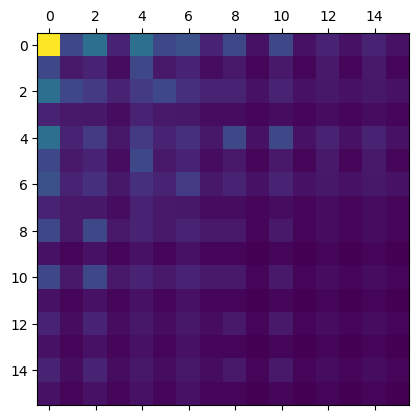

In [174]:
s_marginal = calculate_syndrome_marginal(joint_distribution)
print(s_marginal.shape)
plt.matshow(s_marginal)

In [221]:
sx_idx = np.random.randint(16)
sz_idx = np.random.randint(16)
print(sx_idx, sz_idx)
l_given_s = calculate_logical_prob_given_syndrome(joint_distribution, sx_idx, sz_idx)
print(l_given_s)
print(np.sum(l_given_s))

9 10
[0.25 0.25 0.25 0.25]
0.9999999999999999


### Calculate entropies


In [231]:
def calculate_conditional_entropy_logical_on_stabilizer(joint_distribution):
    """
    Calculates H(L | Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    conditional_entropy = 0
    for l_idx in range(joint_distribution.shape[0]):
        for sx_idx in range(joint_distribution.shape[1]):
            for sz_idx in range(joint_distribution.shape[2]):
                p_stab = np.sum(joint_distribution[:, sx_idx, sz_idx])
                p_joint = joint_distribution[l_idx, sx_idx, sz_idx]
                conditional_entropy += p_joint*np.log2(p_joint/p_stab)
    return -conditional_entropy

def calculate_logical_entropy(joint_distribution):
    """
    Calculates H(L) for a given joint distribution P(L, Sx, Sz)
    """
    l_marginal = calculate_logical_marginal(joint_distribution)
    return -np.sum([p*np.log2(p) for p in l_marginal if p > 0])

In [232]:
Hcond = calculate_conditional_entropy_logical_on_stabilizer(joint_distribution)
Hlogical = calculate_logical_entropy(joint_distribution)

In [233]:
print(Hcond)
print(Hlogical)


1.6035918908860567
1.9313897850729989


### demo for random lattices

In [241]:
def make_random_coloring(num_faces):
    return np.random.choice([-1, 0, 1], num_faces)

In [242]:
def error_distribution_func_1q(pauli_string, rates):
    px = rates[0]
    py = rates[1]
    pz = rates[2]
    probs = {'I': 1-px-py-pz, 'X': px, 'Y': py, 'Z': pz}
    # prob is the joint probability of the error string
    prob = 1
    for p in pauli_string:
        prob *= probs[p]
    return prob

In [244]:
rates = [0.1, 0.1, 0.1]

In [245]:
lat = make_surface_code_lattice(3,3)
lat.color_lattice(make_random_coloring(len(lat.colors)))
print(lat)


000---001---002
 |  #  |  #  |
003---004---005
 |     |     |
006---007---008



In [246]:
joint_distribution = make_joint_distribution(lat, rates)

100%|██████████| 262144/262144 [00:16<00:00, 15830.45it/s]


In [247]:
Hcond = calculate_conditional_entropy_logical_on_stabilizer(joint_distribution)
Hlogical = calculate_logical_entropy(joint_distribution)
print(Hcond)
print(Hlogical)

1.7100357775584347
1.9313897850729926


### Compare surface with shor codes 

In [255]:
lat_surface = make_surface_code_lattice(3,3)
lat_shor_blue = Lattice2D(3,3)
lat_shor_red = Lattice2D(3,3)
lat_shor_blue.color_lattice([1]*4)
lat_shor_red.color_lattice([-1]*4)
print(lat_surface)
print(lat_shor_blue)
print(lat_shor_red)

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [250]:
rates = [0.1, 0.1, 0.1]
joint_surface = make_joint_distribution(lat_surface, rates)
joint_shor_blue = make_joint_distribution(lat_shor_blue, rates)
joint_shor_red = make_joint_distribution(lat_shor_red, rates)

100%|██████████| 262144/262144 [00:19<00:00, 13761.80it/s]


In [251]:
Hcond_surface = calculate_conditional_entropy_logical_on_stabilizer(joint_surface)
Hlogical_surface = calculate_logical_entropy(joint_surface)
Hcond_shor_blue = calculate_conditional_entropy_logical_on_stabilizer(joint_shor_blue)
Hlogical_shor_blue = calculate_logical_entropy(joint_shor_blue)
Hcond_shor_red = calculate_conditional_entropy_logical_on_stabilizer(joint_shor_red)
Hlogical_shor_red = calculate_logical_entropy(joint_shor_red)
print('surface', Hcond_surface, Hlogical_surface)
print('shor_blue', Hcond_shor_blue, Hlogical_shor_blue)
print('shor_red', Hcond_shor_red, Hlogical_shor_red)

surface 1.6035918908860567 1.9313897850729989
shor_blue 1.5819125733433765 1.931389785072999
shor_red 1.581912573343375 1.9313897850729989


In [252]:
rates = [0.09, 0.01, 0.01]
joint_surface = make_joint_distribution(lat_surface, rates)
joint_shor_blue = make_joint_distribution(lat_shor_blue, rates)
joint_shor_red = make_joint_distribution(lat_shor_red, rates)

100%|██████████| 262144/262144 [00:19<00:00, 13419.24it/s]


In [253]:
Hcond_surface = calculate_conditional_entropy_logical_on_stabilizer(joint_surface)
Hlogical_surface = calculate_logical_entropy(joint_surface)
Hcond_shor_blue = calculate_conditional_entropy_logical_on_stabilizer(joint_shor_blue)
Hlogical_shor_blue = calculate_logical_entropy(joint_shor_blue)
Hcond_shor_red = calculate_conditional_entropy_logical_on_stabilizer(joint_shor_red)
Hlogical_shor_red = calculate_logical_entropy(joint_shor_red)
print('surface', Hcond_surface, Hlogical_surface)
print('shor_blue', Hcond_shor_blue, Hlogical_shor_blue)
print('shor_red', Hcond_shor_red, Hlogical_shor_red)

surface 0.4694503669525233 1.1180935167571326
shor_blue 0.5360582872184037 1.1180935167571326
shor_red 0.3885078377376247 1.118093516757133


In [264]:
# calculate the entropies for a range of error rates
rates = [(0.3, 0.3, 0.3), (0.1, 0.1, 0.1), (0.01, 0.01, 0.01), (0.001, 0.001, 0.001), (0.0001, 0.0001, 0.0001)]
Hcond_surface = []
Hlogical_surface = []

lat_surface = make_surface_code_lattice(3,3)
for rate in rates:
    joint_surface = make_joint_distribution(lat_surface, rate)
    Hcond_surface.append(calculate_conditional_entropy_logical_on_stabilizer(joint_surface))
    Hlogical_surface.append(calculate_logical_entropy(joint_surface))


100%|██████████| 262144/262144 [00:19<00:00, 13289.62it/s]


In [265]:
def calculate_rate_entropy_1q(rates, num_qubits):
    p = (1 - sum(rates), *rates)
    H_1q = -sum([p_i*np.log2(p_i) for p_i in p if p_i > 0])
    return H_1q*num_qubits

In [266]:
print(Hcond_surface)
print(Hlogical_surface)
print([calculate_rate_entropy_1q(rate, 9) for rate in rates])

[1.9989659210720498, 1.6035918908860567, 0.051580434544304936, 0.0007194658107871844, 9.0689231877454e-06]
[1.9999075601518346, 1.9313897850729989, 0.625267359879713, 0.1017358748134998, 0.013874002501308545]
[17.0591565981449, 12.211016845023357, 2.177466595678898, 0.3079704541237714, 0.03977151568525381]


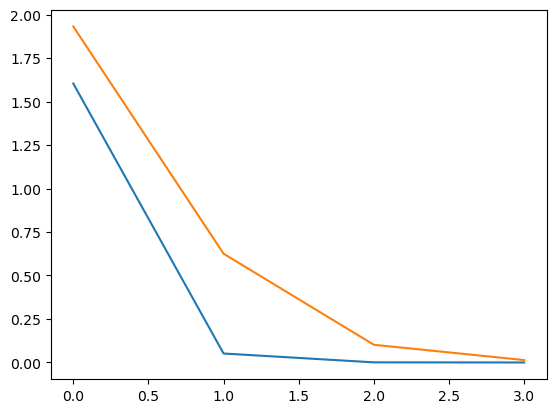

In [261]:
plt.plot(Hcond_surface)
plt.plot(Hlogical_surface)

# stabilizer entropy

In [11]:
rates = [0.01, 0.01, 0.05]
calculate_stabilizer_entropy_exact(parity_check_matrix, error_distribution_func, rates)

  0%|          | 0/262144 [00:00<?, ?it/s]

100%|██████████| 262144/262144 [00:04<00:00, 56559.27it/s]


3.3840779991101404

In [12]:
import itertools as _itr

In [13]:
# make all 3x3 lattices
# first make all length-4 lists of elements in {-1, 0, 1}
# then make all 3x3 lattices
# then calculate the entropy of each lattice
# then plot the entropy of each lattice
# then calculate the entropy of each lattice with a depolarizing channel
# then plot the entropy of each lattice with a depolarizing channel

all_colorings = _itr.product([-1, 0, 1], repeat=4)


lattices = []
for i in all_colorings:
    lat = make_surface_code_lattice(3,3)
    lat.color_lattice(i)
    lattices.append(lat)

In [14]:
rates = [0.01, 0.01, 0.05]
entropies = []
for l in tqdm(lattices):
    entropies.append(calculate_stabilizer_entropy_exact(l.parity_check_matrix(), error_distribution_func, rates))

  7%|▋         | 6/81 [00:28<05:58,  4.78s/it]


KeyboardInterrupt: 

In [15]:
entropies

[2.8027397537313523,
 2.752759383454711,
 3.105688937530992,
 2.75275938345471,
 2.670600410106795,
 3.025327411576127]

In [16]:
# get index of the max entropy
max_idx = np.argmax(entropies)

In [17]:
print(lattices[max_idx])

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [18]:
entropies[max_idx]

3.105688937530992

In [19]:
approx_entropies = []
for l in tqdm(lattices):
    approx_entropies.append(calculate_stabilizer_entropy_emperical(l.parity_check_matrix(), error_distribution_func, rates, 1000))

  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:17<00:00,  4.73it/s]


In [116]:
entropies = np.array(entropies)
approx_entropies = np.array(approx_entropies)
print(entropies-approx_entropies)

[ 0.0942314  -0.01324355 -0.01317728  0.04466563  0.10731451 -0.01910016
  0.1173792   0.06466139  0.0646812  -0.06642519  0.03975739  0.05788281
  0.01567762 -0.02077428  0.06427034  0.13222315  0.04971246  0.04451707
  0.21948158  0.23199594  0.1129785   0.03430621  0.0890309   0.11141723
  0.03032848  0.02830469  0.21107173  0.03580275  0.01091599  0.12962905
  0.10690677  0.01019015  0.02187194  0.28211547 -0.09002567 -0.01684141
  0.06623323  0.18221988 -0.04061239 -0.06656623 -0.01040847  0.04697581
 -0.06268592  0.09165467  0.13252082  0.00196252  0.06708011  0.19232651
  0.04196153 -0.02699652  0.03912775  0.12915131  0.04742969  0.08174643
  0.07484479 -0.02705361  0.08289333  0.07161465 -0.02039262 -0.02192278
  0.13335347  0.10001687 -0.03744467  0.041375    0.1150174   0.18769854
  0.03648673 -0.02785136  0.09073171 -0.01666327 -0.09942309  0.10885059
  0.07475341 -0.05384888  0.12574001  0.00938418  0.03691722  0.00506064
  0.22954643  0.11752144  0.13987416]
